In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import os
from pathlib import Path
from zipfile import ZipFile
import urllib.request
from collections import defaultdict

import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from tfrecord.torch.dataset import MultiTFRecordDataset
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np


# parameters
BATCH_SIZE=256
FEATURES = [
    "elevation",
    "th",
    "vs",
    "tmmn",
    "tmmx",
    "sph",
    "pr",
    "pdsi",
    "NDVI",
    "population",
    "erc",
    "PrevFireMask",
]
LABELS = ["FireMask"]

EPOCHS = 10
LEARNING_RATE = 1e-2

ARR_SIZE = 4096
LENGTH, WIDTH = 64, 64

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 3

In [56]:
# set up data directory
data_dir = os.path.join(os.path.abspath("."), "data")
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [57]:
# download data zip
data_zip = os.path.join(data_dir, "archive.zip")
if not os.path.exists(data_zip):
    url = "https://www.kaggle.com/api/v1/datasets/download/fantineh/next-day-wildfire-spread"
    urllib.request.urlretrieve(url, data_zip)

In [58]:
# extract files from zip
files = defaultdict(list)
file_types = ["eval", "train", "test"]
with ZipFile(data_zip, "r") as z:
    for file in z.namelist():
        for file_type in file_types:
            if file_type in file:
                files[file_type].append(Path(file).stem)
        if not os.path.exists(os.path.join(data_dir, file)):
            z.extract(file, data_dir)

In [59]:
# get all records into a data loader
def get_loader_from_file_type(files: list,  record_path: str, file_types: list):
    f = [file for file_type in file_types for file in files[file_type]][0:2]
    dataset = MultiTFRecordDataset(
        tfrecord_path, 
        None, 
        splits={file: 1.0 for file in f},
        infinite=False
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    return loader

tfrecord_path = os.path.join(data_dir, "{}.tfrecord")
train_loader = get_loader_from_file_type(files, tfrecord_path, ["train"])
test_loader = get_loader_from_file_type(files, tfrecord_path, ["test", "eval"])

In [60]:
data = next(iter(train_loader))
print(data['FireMask'].shape)

data = next(iter(test_loader))
print(data['FireMask'].shape)

torch.Size([256, 4096])
torch.Size([256, 4096])


In [61]:
def get_dataset_items(data, item_list, length=LENGTH, width=WIDTH):
    items = torch.cat([data[key][:, None, :] for key in item_list], dim=1)
    items = items.reshape(items.shape[0], items.shape[1], length, width)
    return items

In [62]:
# gather batch of features
features = get_dataset_items(data, FEATURES)
labels = get_dataset_items(data, LABELS)
print(features.shape)
print(labels.shape)

torch.Size([256, 12, 64, 64])
torch.Size([256, 1, 64, 64])


In [78]:
from models.cnn import CNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = CNN()
rcnn = fasterrcnn_resnet50_fpn(num_classes=num_classes, progress=True)

model.to(device)
rcnn.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [79]:
def make_rcnn_target(labels: list[torch.Tensor], n=2, l=64, w=64):
    """
    length and width should be divisible evenly by n
    i.e., 64x64 image can have 2, 4, 8, etc. evenly spaced boxes
    """
    assert l%n==0
    assert w%n==0
    
    x_step = int(l/n)
    y_step = int(w/n)
    targets = []
    
    for label in labels:
        boxes = torch.zeros((n**2, 4))
        target_labels = torch.zeros((n**2)).type(torch.int64)
        for x in range(n):
            for y in range(n):
                boxes[x*2+y]=torch.Tensor([[x*x_step, y*y_step, (x+1)*x_step-1, (y+1)*y_step-1]])
                target_labels[x*2+y]=torch.Tensor([torch.max(label[0, x*x_step:(x+1)*x_step, y*y_step:(y+1)*y_step])])
        
        targets.append({"boxes": boxes, "labels": target_labels})
    return targets

In [80]:
def train(model, rcnn, loader, optimizer, n=None):
    model.train()
    rcnn.train()
    total_loss = 0
    for i, data in enumerate(loader):
        if n is None:
            n = len(data)
        features = get_dataset_items(data, FEATURES)[0:n]
        labels = get_dataset_items(data, LABELS)[0:n]

        weights = model(features)
        images = weights
        target = make_rcnn_target(labels)
        loss = rcnn(images, target)["loss_classifier"]

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        # if i % 100 == 0:
        loss_val, current = loss.item(), i * BATCH_SIZE + len(features)
        total_loss += loss_val
    print(f"Train loss: {total_loss:>7f}")
    return loss, features, labels

In [81]:
def test(model, rcnn, loader, n=None):
    model.eval()
    rcnn.eval()
    total_loss, correct = 0, 0
    # output = []
    with torch.no_grad():
        for i, data in enumerate(loader):
            if n is None:
                n = len(data)
            features = get_dataset_items(data, FEATURES)[0:n]
            labels = get_dataset_items(data, LABELS)[0:n]
            # Compute prediction and loss
            weights = model(features)
            output = rcnn(weights)
    return output, features, labels

In [82]:
for t in range(EPOCHS):
    print(f'Epoch {t+1}\n')
    # pred, features, labels = train(model, train_loader, loss_fn, optimizer)
    train(model, rcnn, train_loader, optimizer)
    pred, features, labels = test(model, rcnn, test_loader)

Epoch 1
loss: 24.889804


In [83]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [84]:
# visualize features and labels

rows = 5
cols = 14
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

TITLES = [
    'Elevation',
    'Wind Direction',
    'Wind Velocity',
    'Min Temperature',
    'Max Temperature',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population Density',
    'Energy Release Component',
    'Previous Fire Mask',
    'True Fire Mask',
    'Predicted Fire Mask',
]

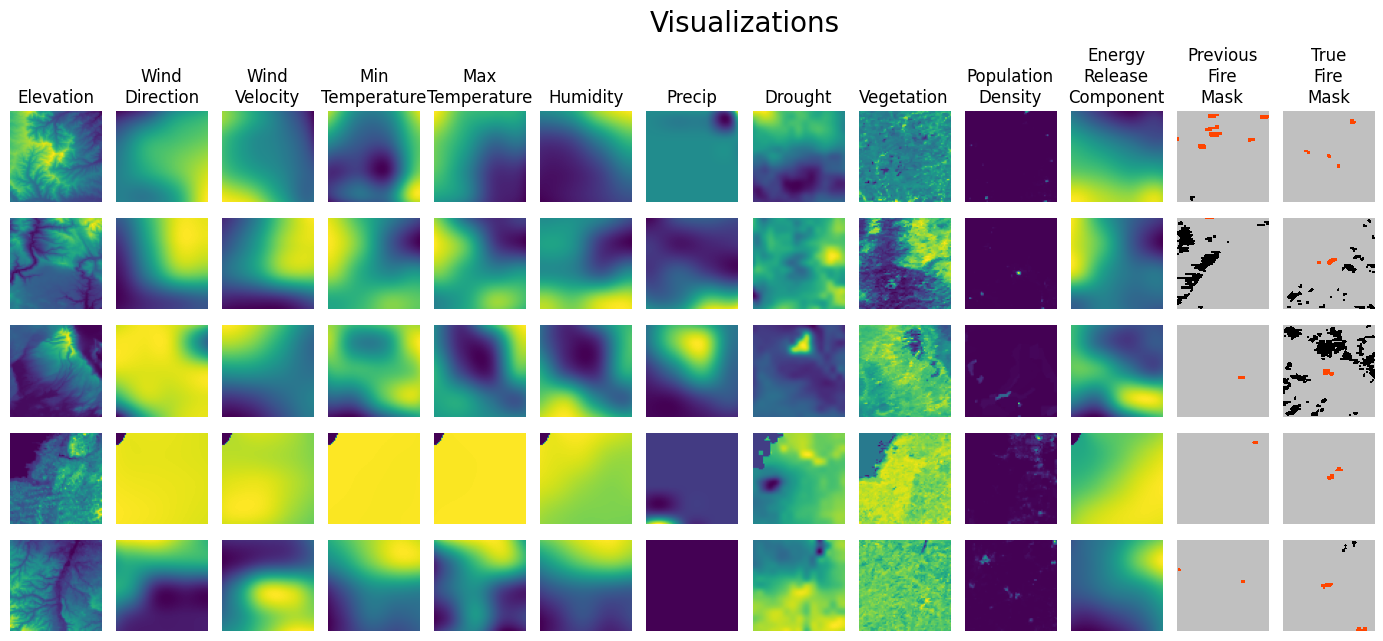

In [85]:
fig = plt.figure(figsize=(15,6.5))
fig.suptitle("Visualizations", fontsize=20)
# samples
for i in range(rows):
    # features and labels
    plots = torch.cat((features[i], labels[i]), dim=0)
    for j, plot in enumerate(plots):
        plot = plot.detach().numpy()
        plt.subplot(rows, cols, i*cols+j+1)
        if i==0:
            title = TITLES[j].replace(' ', '\n')
            plt.title(title)
        if j >= cols-3:
            plt.imshow(plot, cmap=CMAP, norm=NORM)
        else:
            plt.imshow(plot, cmap='viridis')   
        plt.axis('off')
plt.tight_layout()

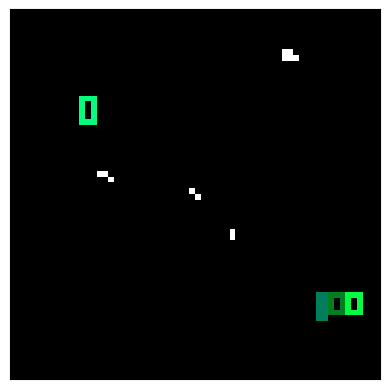

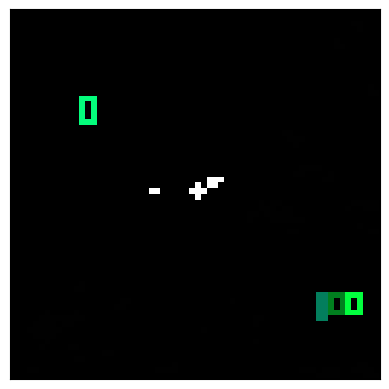

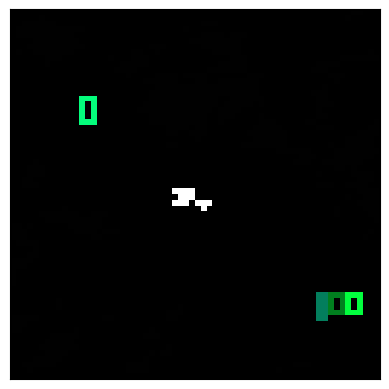

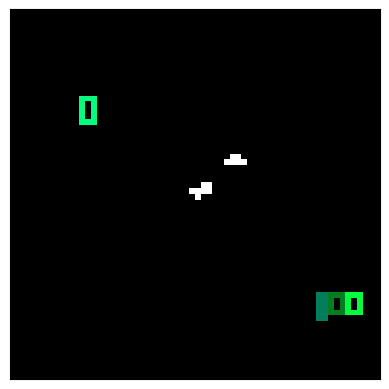

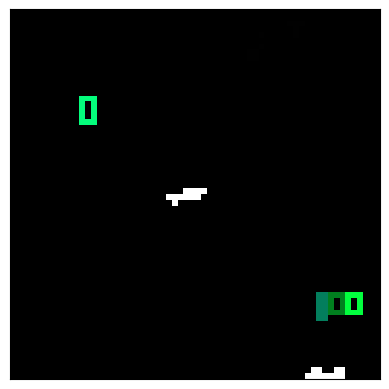

In [87]:
BOXES = 5
for i in range(rows):    
    boxed = draw_bounding_boxes(labels[i], pred[i]['boxes'][0:BOXES])
    show(boxed)